# Préparation des données

In [26]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from csv import reader
from sklearn.preprocessing import StandardScaler

data_base = pd.read_csv('../vessel-total-clean-final.csv')


# Sélection des 150 premiers bateaux par MMSI
mmsi_list = data_base['mmsi'].dropna().unique()[:150]
data_base_150 = data_base[data_base['mmsi'].isin(mmsi_list)].copy()

# Suppression des lignes incomplètes
data_base_150.dropna(subset=['lat', 'lon', 'sog', 'cog'], inplace=True)

# Agrégation des données de navigation par bateau
traj_features = data_base_150.groupby('mmsi').agg({
    'lat': ['mean', 'std'],
    'lon': ['mean', 'std'],
    'sog': ['mean', 'std'],
    'cog': ['mean', 'std']
}).reset_index()

# Nettoyage des noms de colonnes
traj_features.columns = ['mmsi', 'lat_mean', 'lat_std', 'lon_mean', 'lon_std',
                         'sog_mean', 'sog_std', 'cog_mean', 'cog_std']

# Standardisation des données
X = traj_features.drop(columns='mmsi')
X_scaled = StandardScaler().fit_transform(X)


# Apprentissage non-supervisé

1 :
Silhouette Score : 0.28632269949670963
Calinski-Harabasz Score : 63.92417277194908
Davies-Bouldin Score : 1.2611511668463307
2 :
Silhouette Score : 0.28632269949670963
Calinski-Harabasz Score : 63.92417277194908
Davies-Bouldin Score : 1.2611511668463307
3 :
Silhouette Score : 0.28632269949670963
Calinski-Harabasz Score : 63.92417277194908
Davies-Bouldin Score : 1.2611511668463307
4 :
Silhouette Score : 0.28632269949670963
Calinski-Harabasz Score : 63.92417277194908
Davies-Bouldin Score : 1.2611511668463307
5 :
Silhouette Score : 0.28632269949670963
Calinski-Harabasz Score : 63.92417277194908
Davies-Bouldin Score : 1.2611511668463307
6 :
Silhouette Score : 0.28632269949670963
Calinski-Harabasz Score : 63.92417277194908
Davies-Bouldin Score : 1.2611511668463307
7 :
Silhouette Score : 0.28632269949670963
Calinski-Harabasz Score : 63.92417277194908
Davies-Bouldin Score : 1.2611511668463307
8 :
Silhouette Score : 0.28632269949670963
Calinski-Harabasz Score : 63.92417277194908
Davies-Bou

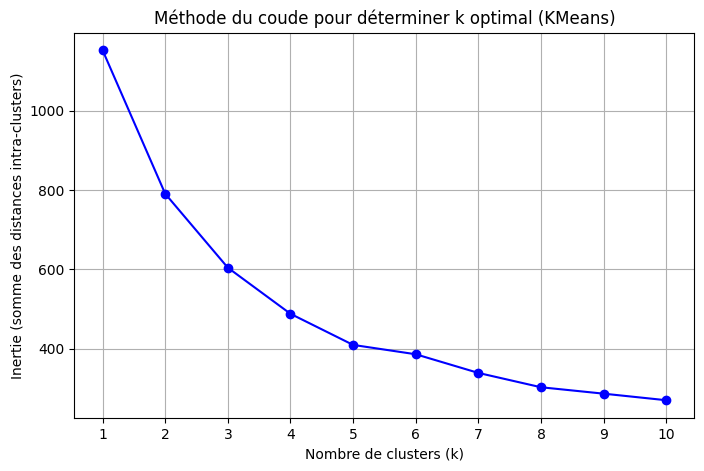

In [33]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


# Apprentisage avec KMEANS
kmeans = KMeans(n_clusters=3, random_state=42)
traj_features['cluster_kmeans'] = kmeans.fit_predict(X_scaled)


# Rattacher les clusters aux trajectoires
df_kmeans = data_base_150.merge(traj_features[['mmsi', 'cluster_kmeans']], on='mmsi')


# Liste pour stocker les inerties
inertias = []

# Tester k de 1 à 10 (tu peux étendre à plus si besoin)
k_range = range(1, 11)

# Boucle sur les différentes valeurs de k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    print(k, ":")
    print("Silhouette Score :", silhouette_score(X_scaled, traj_features['cluster_kmeans']))
    print("Calinski-Harabasz Score :", calinski_harabasz_score(X_scaled, traj_features['cluster_kmeans']))
    print("Davies-Bouldin Score :", davies_bouldin_score(X_scaled, traj_features['cluster_kmeans']))

# Affichage du graphique
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o', linestyle='-', color='blue')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie (somme des distances intra-clusters)")
plt.title("Méthode du coude pour déterminer k optimal (KMeans)")
plt.grid(True)
plt.xticks(k_range)
plt.show()


# Métriques pour l'apprentissage non-supervisé

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

print("Silhouette Score :", silhouette_score(X_scaled, traj_features['cluster_kmeans']))
print("Calinski-Harabasz Score :", calinski_harabasz_score(X_scaled, traj_features['cluster_kmeans']))
print("Davies-Bouldin Score :", davies_bouldin_score(X_scaled, traj_features['cluster_kmeans']))

Silhouette Score : 0.28632269949670963
Calinski-Harabasz Score : 63.92417277194908
Davies-Bouldin Score : 1.2611511668463307


# Visualisation sur un carte

In [31]:
import plotly.express as px

# Visualisation sur carte
fig_kmeans = px.scatter_mapbox(df_kmeans, lat="lat", lon="lon", color="cluster_kmeans",mapbox_style="open-street-map", zoom=5,title="Clustering des trajectoires - KMeans")
fig_kmeans.show(renderer="browser")


C:\Users\alban\AppData\Local\Temp\ipykernel_37064\2540023241.py:4: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

